# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [ ]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

In [130]:
# Import essential libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import os
import glob
import random
from skimage import io
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import classification_report, confusion_matrix

Load the dataset.

In [ ]:
os.getcwd()

In [69]:
# Load and unzip the dataset
# path to your dataset
DATASET_PATH = os.getcwd()+'/data'
waste_cls = ['Cardboard', 'Food_Waste','Glass','Metal','Other','Paper','Plastic']
categories = [folder for folder in os.listdir(DATASET_PATH) if folder != '.DS_Store']
# print(DATASET_PATH)
print(categories)

['Paper', 'Food_Waste', 'Metal', 'Cardboard', 'Other', 'Glass', 'Plastic']


## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [70]:
# Create a function to load the raw images
# loading and assigning labels to each category

def load_images():
    image_paths = []
    labels = []
    for i, category in enumerate(categories):
        category_path = os.path.join(DATASET_PATH, category)
        for img_path in glob.glob(category_path + "/*.png"):
            image_paths.append(img_path)
            labels.append(i)  # Assign a numeric label to each category

#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [71]:
# Get the images and their labels

load_images()
print(len(image_paths))
print(len(labels))

7625
7625


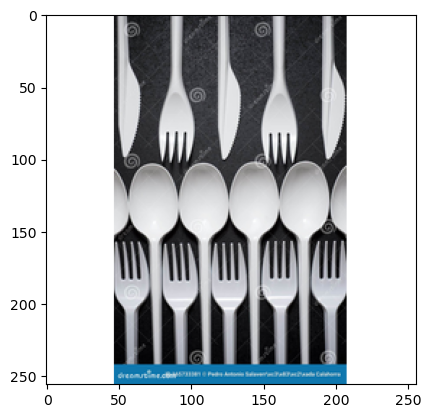

In [72]:
# check some randomly chosen images
rand_index = random.randint(0, len(image_paths))
image = io.imread(image_paths[rand_index])
#print(image_paths[rand_index])
plt.imshow(image)

In [73]:
image.shape

(256, 256, 3)

Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

In [74]:
# creating a dataframe to store label associated with each image

image_df = pd.DataFrame({'image_path': image_paths, 'label': labels})
image_df['category'] = image_df['label'].apply(lambda x: categories[x])
counts = image_df['category'].value_counts()

In [ ]:
#image_df.head()

In [75]:
counts

category
Plastic       2295
Paper         1030
Other         1010
Food_Waste    1000
Metal         1000
Glass          750
Cardboard      540
Name: count, dtype: int64

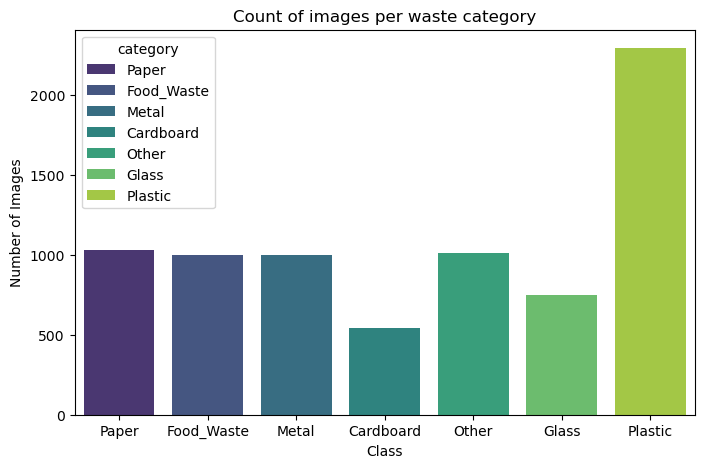

In [76]:
# Visualise Data Distribution

plt.figure(figsize=(8, 5))
sns.countplot(data=image_df, x='category', hue='category',palette='viridis',legend=True)

plt.title('Count of images per waste category')
plt.xlabel('Class')
plt.ylabel('Number of Images')
# plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

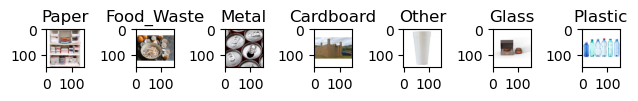

In [137]:
# Visualise Sample Images (across different labels)

# image_df['category'] = image_df['label'].apply(lambda x: categories[x])
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
import random

for i, category in enumerate(categories):
    class_images = image_df[image_df['category'] == category]['image_path'].tolist()
    img_path = random.choice(class_images)
    img = load_img(img_path, target_size=(150, 150))

    plt.subplot(1, len(categories), i + 1)
    plt.imshow(img)
    plt.title(category)
    # plt.axis('off')

plt.tight_layout()
plt.show()

#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [85]:
# Find the smallest and largest image dimensions from the data set

sizes = []

for path in image_paths:
    with Image.open(path) as img: # with is a context manager
        sizes.append(img.size)

sizes = np.array(sizes)
print(sizes.shape)
# print(sizes[10:])
min_width, min_height = sizes.min(axis=0)
max_width, max_height = sizes.max(axis=0)

print(f"Min: {min_width}x{min_height}, Max: {max_width}x{max_height}")

(7625, 2)
[[256 256]
 [256 256]
 [256 256]
 ...
 [256 256]
 [256 256]
 [256 256]]
Min: 256x256, Max: 256x256


In [86]:
# parameters for preprocessing
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32

In [87]:
# Resize the image dimensions

# Preprocessing images as per parameters

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img = img_to_array(img)  # Convert to numpy array
    img = img / 255.0  # Normalize pixel values (0-1)
    return img

images = np.array([preprocess_image(path) for path in image_paths])
labels = np.array(labels)

In [88]:
images.shape

(7625, 150, 150, 3)

### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [91]:
# Encode the labels suitably
from sklearn.preprocessing import OneHotEncoder
waste_cls = ['Cardboard', 'Food_Waste','Glass','Metal','Other','Paper','Plastic']
waste_cls_array = np.array(waste_cls).reshape(-1, 1)
ohe = OneHotEncoder(sparse_output=False)
encoded_data = ohe.fit_transform(waste_cls_array)

print(encoded_data)

[[1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]]


### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [93]:
# Assign specified parts of the dataset to train and validation sets
X_train, X_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, stratify=labels, random_state=42)

#Further Splitting X_train into Train + Validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

In [100]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_val = np.array(X_val)
y_val = np.array(y_val)
print("Training data")
print(X_train.shape)
print(y_train.shape)
print("Test data")
print(X_test.shape)
print(y_test.shape)
print("Validation data")
print(X_val.shape)
print(y_val.shape)

In [102]:
from tensorflow.keras.utils import to_categorical

def preprocess_images_and_labels(image_paths, labels, img_size=(150, 150), num_classes=7):
    X_data = []
    y_data = []

    for path, label in zip(image_paths, labels):
        try:
            img = Image.open(path).convert('RGB')  # Ensure 3 channels
            img = img.resize(img_size)
            img_array = np.array(img) / 255.0       # Normalize
            X_data.append(img_array)
            y_data.append(label)
        except Exception as e:
            print(f"Error processing {path}: {e}")
            continue

    X_data = np.array(X_data)
    y_data = to_categorical(y_data, num_classes=num_classes)

    return X_data, y_data


In [105]:
X_train_data, y_train_data = preprocess_images_and_labels(X_train, y_train)
X_val_data, y_val_data = preprocess_images_and_labels(X_val, y_val)
X_test_data, y_test_data = preprocess_images_and_labels(X_test, y_test)

In [106]:
print("Training data after preprocessing and normalization")
print(X_train_data.shape)
print(y_train_data.shape)
print("Test data after preprocessing and normalization")
print(X_test_data.shape)
print(y_test_data.shape)
print("Validation data after preprocessing and normalization")
print(X_val_data.shape)
print(y_val_data.shape)

Training data after preprocessing and normalization
(4880, 150, 150, 3)
(4880, 7)
Test data after preprocessing and normalization
(1525, 150, 150, 3)
(1525, 7)
Validation data after preprocessing and normalization
(1220, 150, 150, 3)
(1220, 7)


## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [109]:
# Build and compile the model

def create_cnn_model(input_shape=(150, 150, 3), num_classes=7):
    model = Sequential()

    # 1st Convolutional Block
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # 2nd Convolutional Block
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # 3rd Convolutional Block
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # Dropout for regularization
    model.add(Dense(num_classes, activation='softmax'))  # Output layer

    return model

In [120]:
# Second model with dropout layer of 0.3 before Fully connected layer

def create_cnn_model_2(input_shape=(150, 150, 3), num_classes=7):
    model_2 = Sequential()

    # 1st Convolutional Block
    model_2.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
    model_2.add(BatchNormalization())
    model_2.add(MaxPooling2D(pool_size=(2, 2)))

    # 2nd Convolutional Block
    model_2.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model_2.add(BatchNormalization())
    model_2.add(MaxPooling2D(pool_size=(2, 2)))

    # 3rd Convolutional Block
    model_2.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model_2.add(BatchNormalization())
    model_2.add(MaxPooling2D(pool_size=(2, 2)))

    # Fully Connected Layers
    model_2.add(Flatten())
    model_2.add(Dense(128, activation='relu'))
    model_2.add(Dropout(0.3))  # Dropout for regularization
    model_2.add(Dense(num_classes, activation='softmax'))  # Output layer

    return model_2

In [121]:
#model = create_cnn_model()
model_2 = create_cnn_model_2()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [111]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     5,308,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,403,591 (20.61 MB)

 Trainable params: 5,403,143 (20.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [122]:
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     5,308,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,403,591 (20.61 MB)

 Trainable params: 5,403,143 (20.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [113]:
# compiling model with SGD

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(learning_rate=0.01,momentum=0.9) ,
              metrics=['accuracy'])

In [123]:
# compiling second model with SGD
# using learning rate - 0.001
model_2.compile(loss='categorical_crossentropy',
              optimizer=SGD(learning_rate=0.001,momentum=0.9) ,
              metrics=['accuracy'])

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [114]:
# Training
# Checking with 10 epochs and 32 batch
epochs = 10
batch_size = 32
model.fit(X_train_data, y_train_data,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val_data, y_val_data))

Epoch 1/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 63s 404ms/step - accuracy: 0.2621 - loss: 2.7154 - val_accuracy: 0.2418 - val_loss: 2.3866
Epoch 2/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 65s 423ms/step - accuracy: 0.3136 - loss: 1.8381 - val_accuracy: 0.2730 - val_loss: 1.9972
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 136s 888ms/step - accuracy: 0.3069 - loss: 1.8428 - val_accuracy: 0.3000 - val_loss: 1.8484
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 65s 428ms/step - accuracy: 0.2997 - loss: 1.8532 - val_accuracy: 0.3008 - val_loss: 1.8480
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 226s 1s/step - accuracy: 0.3075 - loss: 1.8419 - val_accuracy: 0.3008 - val_loss: 1.8480
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 64s 418ms/step - accuracy: 0.2980 - loss: 1.8500 - val_accuracy: 0.3008 - val_loss: 1.8481
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 67s 441ms/step - accuracy: 0.2987 - loss: 1.8551 - val_accuracy: 0.3008 - val_loss: 1.8481
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 67s 439ms/step - accuracy: 0.2861 - loss: 1.

In [124]:
# Training
# Checking with 20 epochs and 16 batch
epochs = 20
batch_size = 16
model_2.fit(X_train_data, y_train_data,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val_data, y_val_data))

Epoch 1/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 64s 209ms/step - accuracy: 0.2821 - loss: 2.1326 - val_accuracy: 0.2844 - val_loss: 2.0663
Epoch 2/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 65s 212ms/step - accuracy: 0.3432 - loss: 1.6378 - val_accuracy: 0.4057 - val_loss: 1.5708
Epoch 3/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 66s 217ms/step - accuracy: 0.4000 - loss: 1.5009 - val_accuracy: 0.3754 - val_loss: 1.7321
Epoch 4/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 67s 220ms/step - accuracy: 0.4456 - loss: 1.4113 - val_accuracy: 0.3926 - val_loss: 1.7026
Epoch 5/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 95s 312ms/step - accuracy: 0.4875 - loss: 1.3099 - val_accuracy: 0.4639 - val_loss: 1.4946
Epoch 6/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 90s 295ms/step - accuracy: 0.5219 - loss: 1.2206 - val_accuracy: 0.3385 - val_loss: 1.9299
Epoch 7/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 93s 305ms/step - accuracy: 0.5807 - loss: 1.0982 - val_accuracy: 0.4721 - val_loss: 1.5894
Epoch 8/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 89s 291ms/step - accuracy: 0.6133 - loss: 1

### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

In [ ]:
# Evaluate on the test set; display suitable metrics

# loss, accuracy = model.evaluate(X_test_data, y_test_data)
# print("Test Loss : {}".format(loss))
# print("Test Accuracy : {} ".format(accuracy))

### Test Loss with model_2

In [125]:
loss, accuracy = model_2.evaluate(X_test_data, y_test_data)
print("Test Loss : {}".format(loss))
print("Test Accuracy : {} ".format(accuracy))

48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.5890 - loss: 1.8753
Test Loss : 1.7772140502929688
Test Accuracy : 0.6072131395339966 


In [139]:
# Evaluate on the validation set using model_1; 

# val_loss, val_accuracy = model.evaluate(X_val_data, y_val_data)
# print("Validation Loss : {} ".format(val_loss))
# print("Validation Accuracy : {} ".format(val_accuracy))

### Validation Loss with model_2

In [126]:
# Evaluate on the validation set; 

val_loss, val_accuracy = model_2.evaluate(X_val_data, y_val_data)
print("Validation Loss : {} ".format(val_loss))
print("Validation Accuracy : {} ".format(val_accuracy))

39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.5710 - loss: 1.8268
Validation Loss : 1.7441152334213257 
Validation Accuracy : 0.5877048969268799 


In [127]:
# Predict probabilities
y_pred_probs = model_2.predict(X_test_data)

# Convert predictions and true labels from one-hot to class index
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_data, axis=1)

48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step


In [133]:
# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN)
# F1 = 2 * (Precision * Recall) / (Precision + Recall)
# Accuracy = (Total correct predictions) / (Total predictions)

In [128]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=categories))

              precision    recall  f1-score   support

       Paper       0.67      0.50      0.57       206
  Food_Waste       0.61      0.57      0.59       200
       Metal       0.61      0.59      0.60       200
   Cardboard       0.77      0.70      0.73       108
       Other       0.60      0.31      0.41       202
       Glass       0.69      0.46      0.55       150
     Plastic       0.56      0.83      0.67       459

    accuracy                           0.61      1525
   macro avg       0.64      0.57      0.59      1525
weighted avg       0.62      0.61      0.60      1525



In [132]:
cm = confusion_matrix(y_true, y_pred)
print("CONFUSION MATRIX")
print(cm)

CONFUSION MATRIX
[[103  19  21   7   2   5  49]
 [  9 115  15   8  10   4  39]
 [ 13   7 118   1   8   6  47]
 [  0  11   5  76   2   1  13]
 [  7  11  17   3  63   8  93]
 [  4   5   5   1   2  69  64]
 [ 17  20  12   3  18   7 382]]


## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [ ]:
# Define augmentation steps to augment images



Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [140]:
# Create a function to augment the images

def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label

In [ ]:
# Create the augmented training dataset

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_data, y_train_data))
train_dataset = (
    train_dataset
    .map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(1000)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)


##### **4.1.2**

Train the model on the new augmented dataset.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


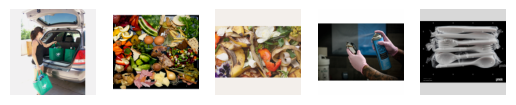

2025-04-22 20:52:14.095027: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [142]:
# Train the model using augmented images

for images, labels in train_dataset.take(1):
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(images[i].numpy())
        plt.axis('off')
    plt.show()

## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data
* Report model training results

1) We achieved a test accuracy of 60% and test loss of 1.7
    Test Loss : 1.7772140502929688
    Test Accuracy : 0.6072131395339966

2) We achieved a validation accuracy of 58% and test loss of 1.7
   Validation Loss : 1.7441152334213257 
   Validation Accuracy : 0.5877048969268799
   
3) Accuracy of about 60%